In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 540

nband = 80

nv = 200

dv = 0.005

tsfc =257

ng =9

nref =3

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

ng_refs = (/ 3 , 2 , 4 /) 

data wgt
     &     /0.7 , 0.3 , 0.7 , 0.7,
     &     0.6 , 0.4 , 0.5 , 0.8,
     &     0.95/

option_wgt_flux =2

option_wgt_k =1

option_klin =1

data w_diffuse
     &     /1.6 , 1.6 , 1.7 , 1.75,
     &     1.75 , 1.55 , 1.55 , 1.6,
     &     1.85/

klin =6.375563e-24

atmosphere_profiles/saw75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

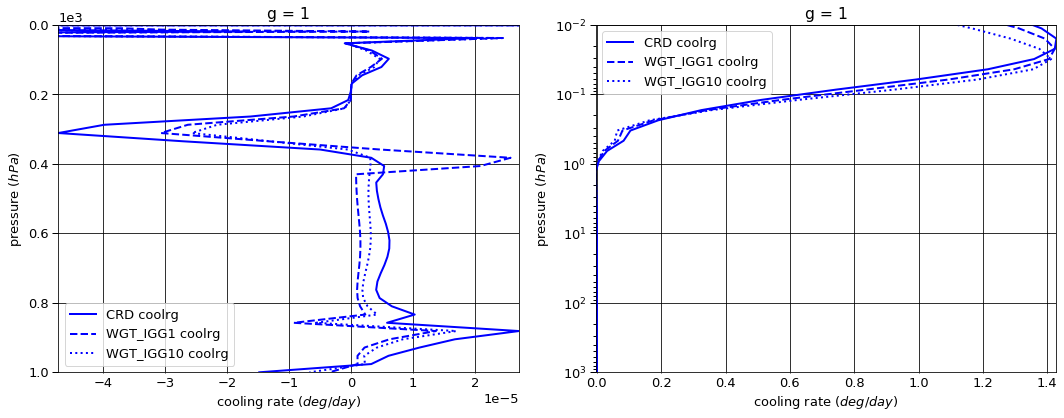

# Figure: cooling rate g-group 2

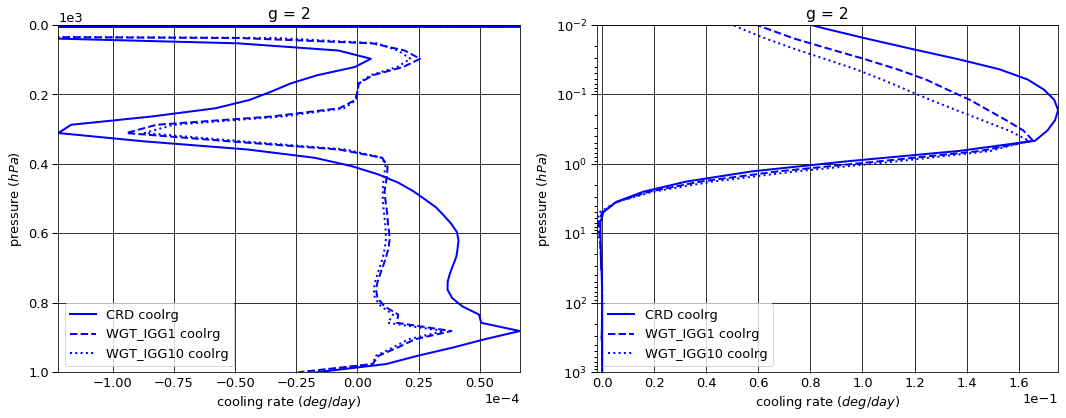

# Figure: cooling rate g-group 3

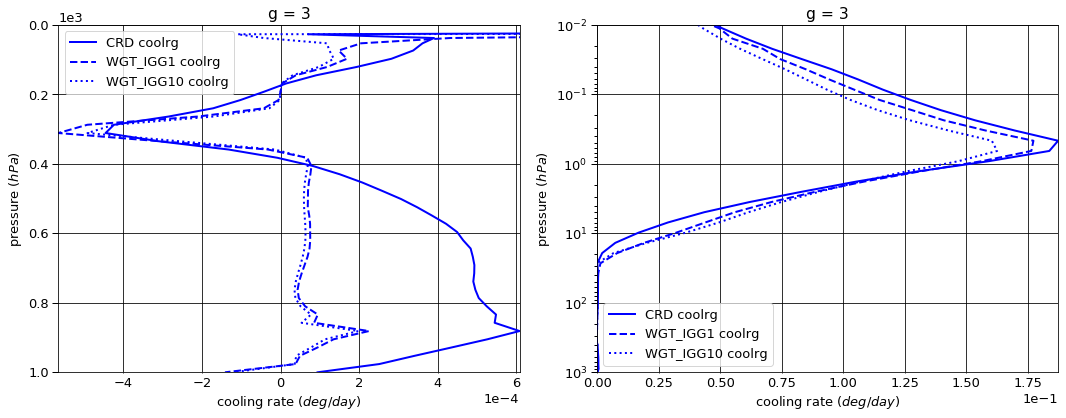

# Figure: cooling rate g-group 4

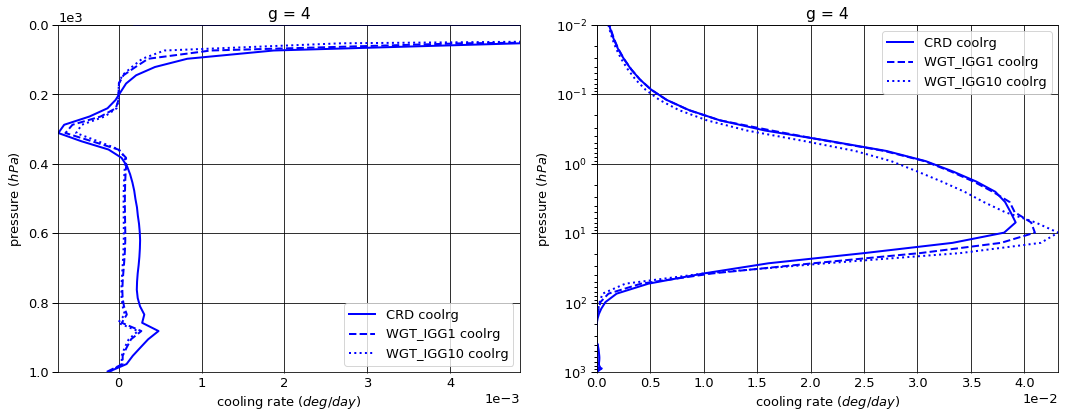

# Figure: cooling rate g-group 5

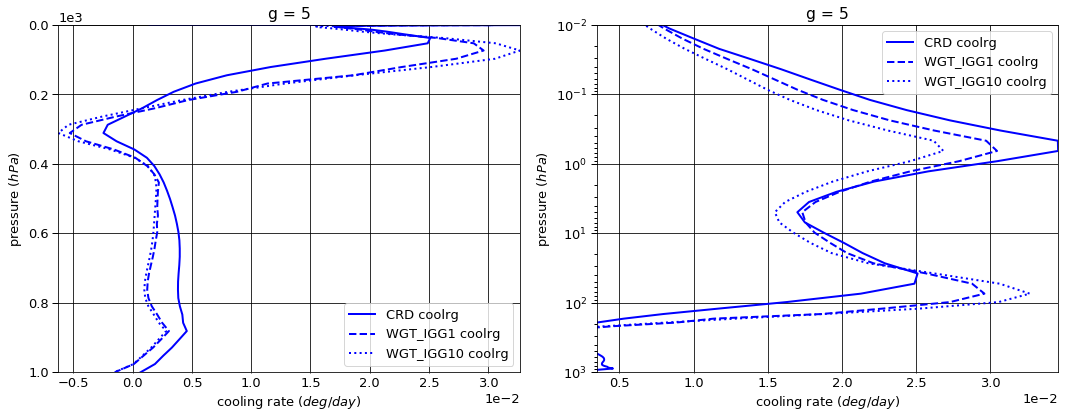

# Figure: cooling rate g-group 6

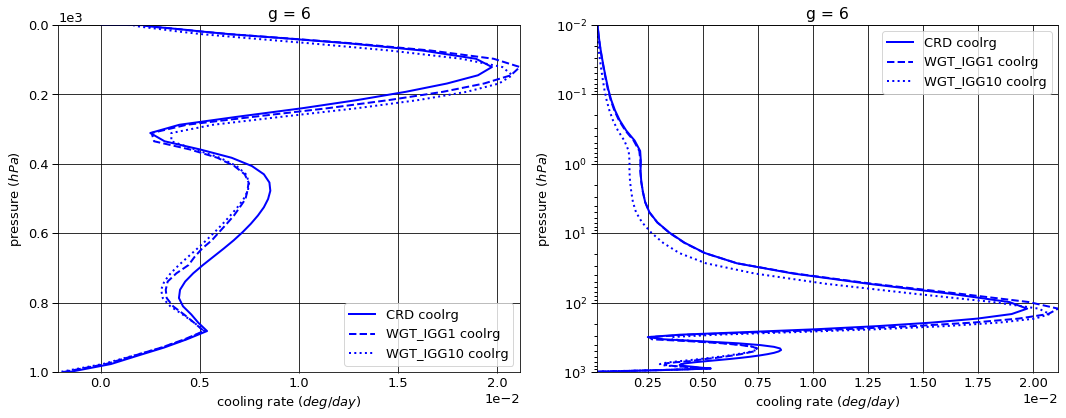

# Figure: cooling rate g-group 7

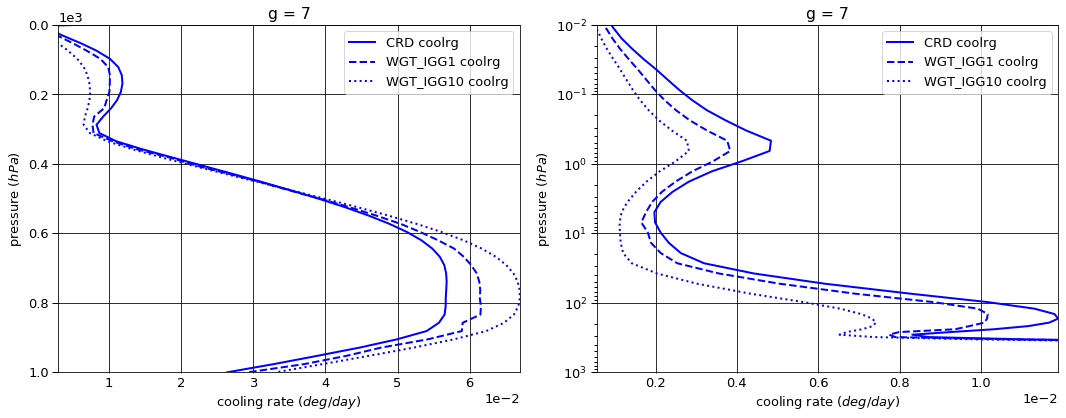

# Figure: cooling rate g-group 8

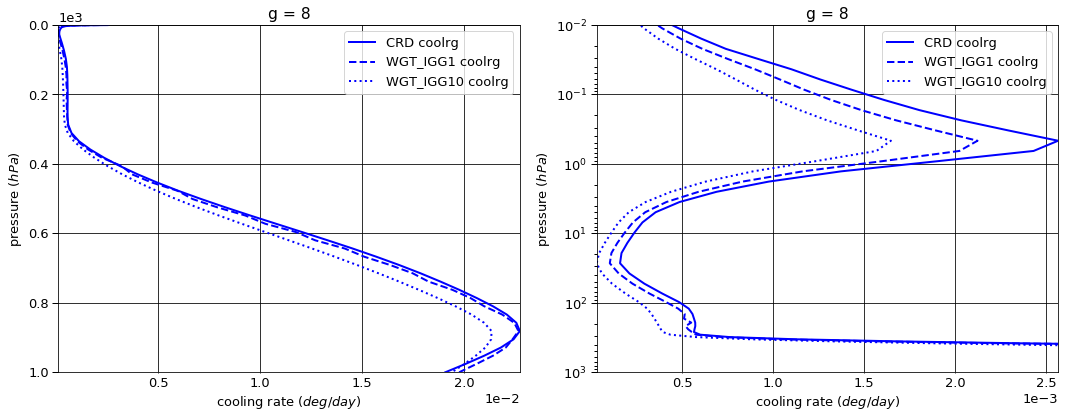

# Figure: cooling rate g-group 9

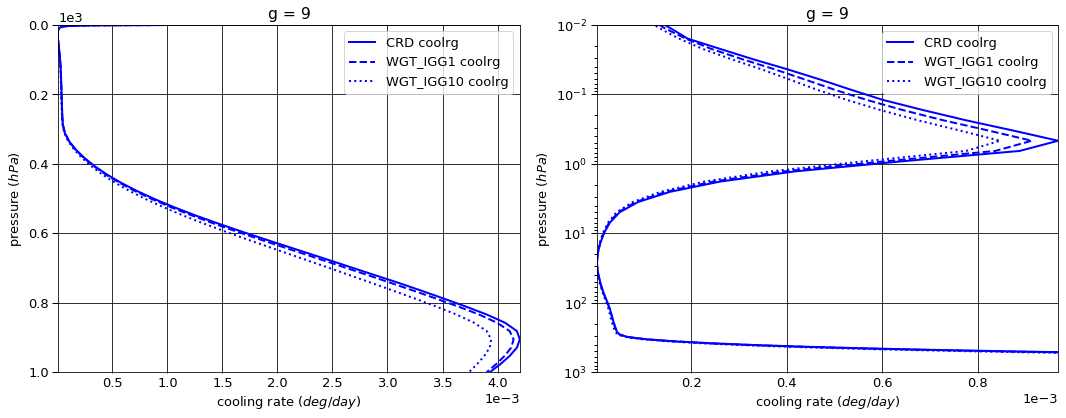

# Figure: cooling rate g-group total

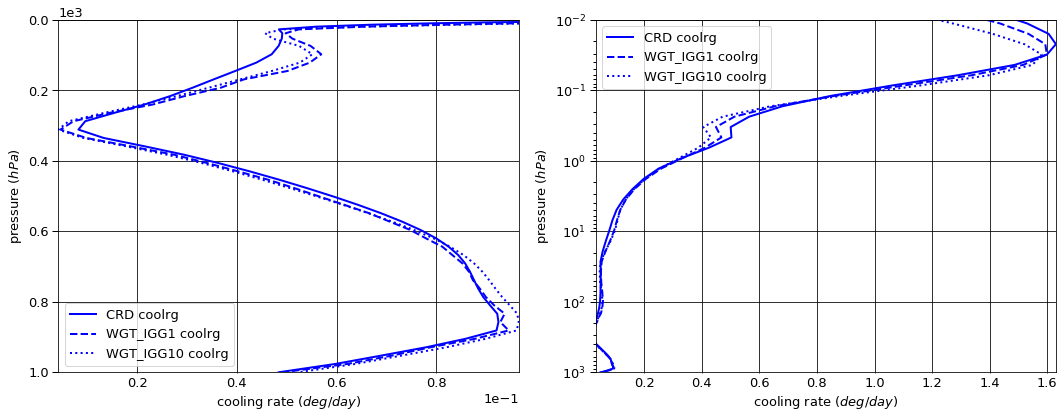

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.021865  0.000000 -0.021865
  1013.0   76    -0.025928  0.025990  0.000062
2 0.0      1     -0.024052  0.000000 -0.024052
  1013.0   76    -0.028855  0.028883  0.000028
3 0.0      1     -0.118529  0.000000 -0.118529
  1013.0   76    -0.179669  0.169207 -0.010461
4 0.0      1     -0.148893  0.000000 -0.148893
  1013.0   76    -0.282707  0.281898 -0.000809
5 0.0      1     -0.686373  0.000000 -0.686373
  1013.0   76    -1.136347  1.044846 -0.091501
6 0.0      1     -0.883894  0.000000 -0.883894
  1013.0   76    -1.549608  1.563235  0.013627
7 0.0      1     -4.926609  0.000000 -4.926609
  1013.0   76    -6.175988  5.127564 -1.048424
8 0.0      1     -5.194761  0.000000 -5.194761
  1013.0   76    -5.365031  1.320211 -4.044819
9 0.0      1     -8.829698  0.000000 -8.829698
  1013.0   76    -8.847005  0.207390 -8.639615


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.021815  0.000000 -0.021815
  1013.0   76    -0.025928  0.025940  0.000012
2 0.0      1     -0.024221  0.000000 -0.024221
  1013.0   76    -0.028855  0.028946  0.000091
3 0.0      1     -0.108761  0.000000 -0.108761
  1013.0   76    -0.179669  0.180188  0.000520
4 0.0      1     -0.146171  0.000000 -0.146171
  1013.0   76    -0.282707  0.283247  0.000540
5 0.0      1     -0.592393  0.000000 -0.592393
  1013.0   76    -1.136347  1.145774  0.009427
6 0.0      1     -0.857939  0.000000 -0.857939
  1013.0   76    -1.549608  1.565250  0.015641
7 0.0      1     -4.923672  0.000000 -4.923672
  1013.0   76    -6.175988  5.279335 -0.896653
8 0.0      1     -5.201201  0.000000 -5.201201
  1013.0   76    -5.365031  1.297017 -4.068014
9 0.0      1     -8.830372  0.000000 -8.830372
  1013.0   76    -8.847005  0.203228 -8.643777


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.021895  0.000000 -0.021895
  1013.0   76    -0.025928  0.025951  0.000023
2 0.0      1     -0.024349  0.000000 -0.024349
  1013.0   76    -0.028855  0.028935  0.000080
3 0.0      1     -0.108432  0.000000 -0.108432
  1013.0   76    -0.179669  0.180097  0.000429
4 0.0      1     -0.145684  0.000000 -0.145684
  1013.0   76    -0.282707  0.283117  0.000410
5 0.0      1     -0.589949  0.000000 -0.589949
  1013.0   76    -1.136347  1.144835  0.008488
6 0.0      1     -0.852326  0.000000 -0.852326
  1013.0   76    -1.549608  1.565769  0.016161
7 0.0      1     -4.989494  0.000000 -4.989494
  1013.0   76    -6.175988  5.356737 -0.819251
8 0.0      1     -5.226511  0.000000 -5.226511
  1013.0   76    -5.365031  1.178115 -4.186916
9 0.0      1     -8.831505  0.000000 -8.831505
  1013.0   76    -8.847005  0.191923 -8.655082


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      5.067500e-05  0.000000  0.000051
  1013.0   76     3.469447e-18 -0.000050 -0.000050
2 0.0      1     -1.691020e-04  0.000000 -0.000169
  1013.0   76     3.469447e-18  0.000063  0.000063
3 0.0      1      9.767720e-03  0.000000  0.009768
  1013.0   76     0.000000e+00  0.010981  0.010981
4 0.0      1      2.722270e-03  0.000000  0.002722
  1013.0   76     0.000000e+00  0.001349  0.001349
5 0.0      1      9.397980e-02  0.000000  0.093980
  1013.0   76     0.000000e+00  0.100928  0.100928
6 0.0      1      2.595509e-02  0.000000  0.025955
  1013.0   76    -2.220446e-16  0.002014  0.002015
7 0.0      1      2.936700e-03  0.000000  0.002937
  1013.0   76     0.000000e+00  0.151771  0.151771
8 0.0      1     -6.440400e-03  0.000000 -0.006440
  1013.0   76     0.000000e+00 -0.023194 -0.023194
9 0.0      1     -6.735000e-04  0.000000 -0.000673
  1013.0   76     0.000000e+00 -0.004162 -0.004162


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -3.017900e-05  0.000000 -0.000030
  1013.0   76     3.469447e-18 -0.000038 -0.000038
2 0.0      1     -2.978130e-04  0.000000 -0.000298
  1013.0   76     3.469447e-18  0.000052  0.000052
3 0.0      1      1.009707e-02  0.000000  0.010097
  1013.0   76     0.000000e+00  0.010890  0.010890
4 0.0      1      3.209710e-03  0.000000  0.003210
  1013.0   76     0.000000e+00  0.001219  0.001219
5 0.0      1      9.642385e-02  0.000000  0.096424
  1013.0   76     0.000000e+00  0.099989  0.099989
6 0.0      1      3.156804e-02  0.000000  0.031568
  1013.0   76    -2.220446e-16  0.002534  0.002534
7 0.0      1     -6.288480e-02  0.000000 -0.062885
  1013.0   76     0.000000e+00  0.229172  0.229172
8 0.0      1     -3.175090e-02  0.000000 -0.031751
  1013.0   76     0.000000e+00 -0.142097 -0.142097
9 0.0      1     -1.806900e-03  0.000000 -0.001807
  1013.0   76     0.000000e+00 -0.015467 -0.015467

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.341930
  1001.112500 75    -0.000015
2 0.000312    1      0.004687
  1001.112500 75    -0.000017
3 0.000312    1      0.008392
  1001.112500 75     0.000094
4 0.000312    1      0.000188
  1001.112500 75    -0.000134
5 0.000312    1      0.001417
  1001.112500 75     0.000661
6 0.000312    1      0.000046
  1001.112500 75    -0.001646
7 0.000312    1      0.000126
  1001.112500 75     0.026418
8 0.000312    1      0.000019
  1001.112500 75     0.019065
9 0.000312    1      0.000001
  1001.112500 75     0.003928


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      2.562314e-01
  1001.112500 75    -3.480578e-06
2 0.000312    1      4.876302e-03
  1001.112500 75    -2.430503e-05
3 0.000312    1      9.462395e-03
  1001.112500 75    -1.414534e-04
4 0.000312    1      2.150020e-04
  1001.112500 75    -1.541058e-04
5 0.000312    1      2.071425e-03
  1001.112500 75    -1.516271e-03
6 0.000312    1      4.581284e-05
  1001.112500 75    -1.947631e-03
7 0.000312    1      1.165220e-04
  1001.112500 75     2.930825e-02
8 0.000312    1      1.205223e-05
  1001.112500 75     1.974383e-02
9 0.000312    1     -1.667212e-07
  1001.112500 75     3.900233e-03


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.449621e-01
  1001.112500 75    -6.718994e-06
2 0.000312    1      5.157506e-03
  1001.112500 75    -2.203017e-05
3 0.000312    1      9.668783e-03
  1001.112500 75    -1.198623e-04
4 0.000312    1      2.007643e-04
  1001.112500 75    -1.177308e-04
5 0.000312    1      1.830864e-03
  1001.112500 75    -1.566973e-03
6 0.000312    1      3.470864e-05
  1001.112500 75    -2.126544e-03
7 0.000312    1      6.032771e-05
  1001.112500 75     3.311144e-02
8 0.000312    1     -1.701555e-08
  1001.112500 75     1.938285e-02
9 0.000312    1     -3.906972e-07
  1001.112500 75     3.739087e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -8.569851e-02
  1001.112500 75     1.134954e-05
2 0.000312    1      1.892123e-04
  1001.112500 75    -7.543484e-06
3 0.000312    1      1.070178e-03
  1001.112500 75    -2.355377e-04
4 0.000312    1      2.693326e-05
  1001.112500 75    -1.992938e-05
5 0.000312    1      6.539270e-04
  1001.112500 75    -2.177162e-03
6 0.000312    1      8.467600e-08
  1001.112500 75    -3.014018e-04
7 0.000312    1     -9.178420e-06
  1001.112500 75     2.889968e-03
8 0.000312    1     -7.095604e-06
  1001.112500 75     6.786160e-04
9 0.000312    1     -1.614688e-06
  1001.112500 75    -2.778990e-05


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.196968
  1001.112500 75     0.000008
2 0.000312    1      0.000470
  1001.112500 75    -0.000005
3 0.000312    1      0.001277
  1001.112500 75    -0.000214
4 0.000312    1      0.000013
  1001.112500 75     0.000016
5 0.000312    1      0.000413
  1001.112500 75    -0.002228
6 0.000312    1     -0.000011
  1001.112500 75    -0.000480
7 0.000312    1     -0.000065
  1001.112500 75     0.006693
8 0.000312    1     -0.000019
  1001.112500 75     0.000318
9 0.000312    1     -0.000002
  1001.112500 75    -0.000189

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.834674,0.000000,-20.834674
1013.0,76,-23.591138,9.769225,-13.821912



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.706544,0.000000,-20.706544
1013.0,76,-23.591138,10.008925,-13.582213



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.790145,0.00000,-20.790145
1013.0,76,-23.591138,9.95548,-13.635658



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.128129,0.0000,0.128129
1013.0,76,0.000000,0.2397,0.239700



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.044528,0.000000,0.044528
1013.0,76,0.000000,0.186254,0.186254


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.356807
1001.112500,75,0.048354



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.273031
1001.112500,75,0.049165



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.161915
1001.112500,75,0.052274



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.083776
1001.112500,75,0.000811



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.194892
1001.112500,75,0.003919


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001125,0.001094
2,0.001250,0.001218
3,0.007750,0.007589
4,0.012250,0.011931
5,0.048938,0.048008
6,0.066937,0.065427
7,0.265437,0.261001
8,0.226562,0.227542
9,0.369750,0.376189


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.213044e-19
2,2.053870e-20
3,1.906144e-21
4,1.715202e-21
5,1.602800e-22
6,6.938182e-22
7,6.651099e-23
8,6.375895e-24
9,1.011442e-25


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.213044e-19,NaN,0.001125,0.001094,0.001125,0.001094,1.0
2,2.053870e-20,0.092807,0.001250,0.001218,0.002375,0.002312,1.0
3,1.906144e-21,0.092807,0.007750,0.007589,0.010125,0.009900,1.0
4,1.715202e-21,0.899828,0.012250,0.011931,0.022375,0.021832,10.0
5,1.602800e-22,0.093447,0.048938,0.048008,0.071313,0.069840,10.0
6,6.938182e-22,4.328789,0.066937,0.065427,0.138250,0.135267,500.0
7,6.651099e-23,0.095862,0.265437,0.261001,0.403687,0.396268,500.0
8,6.375895e-24,0.095862,0.226562,0.227542,0.630250,0.623811,500.0
9,1.011442e-25,0.015864,0.369750,0.376189,1.000000,1.000000,500.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     6.220373e-19  3.923414e-19   1.585449  2.927974e-03
      2 0.000312     2.277231e-20  1.417958e-20   1.605994  8.870493e-05
      3 0.000312     1.509329e-21  8.248466e-22   1.829830  6.902612e-06
      4 0.000312     1.382861e-23  1.260182e-23   1.097350  7.125326e-08
      5 0.000312     3.903032e-23  1.698251e-23   2.298265  1.599223e-07
      6 0.000312     5.247383e-25  5.123286e-25   1.024222  2.738277e-09
      7 0.000312     7.581177e-25  5.079255e-25   1.492576  3.350886e-09
      8 0.000312     4.881123e-25  1.213121e-25   4.023608  2.195482e-09
      9 0.000312     8.645124e-26  4.243866e-27  20.370870  4.358697e-10
2     1 0.000750     6.374452e-19  4.011123e-19   1.589194  1.207956e-03
      2 0.000750     2.358109e-20  1.459447e-20   1.615755  3.686572e-05
      3 0.000750     1.567493e-21  8.492315e-22   1.845778  2.882688e-06
      4 0.000750     1.468900e-23  1.335933e-23   1.099531  3.046853e-08
      5 0.000750     4.048519e-23  1.741188e-23   2.325147  6.664196e-08
      6 0.000750     5.498353e-25  5.365602e-25   1.024741  1.155345e-09
      7 0.000750     7.920727e-25  5.270344e-25   1.502886  1.406262e-09
      8 0.000750     5.142759e-25  1.251379e-25   4.109674  9.305701e-10
      9 0.000750     9.221880e-26  4.365515e-27  21.124379  1.872578e-10
3     1 0.001052     6.693821e-19  4.193237e-19   1.596337  1.777201e-03
      2 0.001052     2.528968e-20  1.545588e-20   1.636250  5.503559e-05
      3 0.001052     1.690936e-21  8.985980e-22   1.881749  4.345297e-06
      4 0.001052     1.637762e-23  1.481249e-23   1.105663  4.756653e-08
      5 0.001052     4.358646e-23  1.828556e-23   2.383655  1.000665e-07
      6 0.001052     6.032222e-25  5.879390e-25   1.025994  1.776268e-09
      7 0.001052     8.654315e-25  5.672536e-25   1.525652  2.141926e-09
      8 0.001052     5.714801e-25  1.330223e-25   4.296121  1.446569e-09
      9 0.001052     1.050673e-25  4.616888e-27  22.757162  2.991424e-10
4     1 0.001476     7.027818e-19  4.384669e-19   1.602816  2.615385e-03
      2 0.001476     2.713287e-20  1.636765e-20   1.657713  8.220577e-05
      3 0.001476     1.825587e-21  9.501639e-22   1.921339  6.556255e-06
      4 0.001476     1.831149e-23  1.646506e-23   1.112142  7.448884e-08
      5 0.001476     4.698544e-23  1.920000e-23   2.447158  1.504716e-07
      6 0.001476     6.641872e-25  6.464427e-25   1.027450  2.741451e-09
      7 0.001476     9.473814e-25  6.108226e-25   1.550993  3.268152e-09
      8 0.001476     6.360225e-25  1.413768e-25   4.498776  2.252982e-09
      9 0.001476     1.199001e-25  4.884833e-27  24.545388  4.788301e-10
5     1 0.002070     7.372427e-19  4.583380e-19   1.608513  3.845304e-03
      2 0.002070     2.909610e-20  1.731993e-20   1.679921  1.226879e-04
      3 0.002070     1.970694e-21  1.003287e-21   1.964236  9.887101e-06
      4 0.002070     2.051400e-23  1.833542e-23   1.118818  1.168493e-07
      5 0.002070     5.066909e-23  2.014413e-23   2.515328  2.262752e-07
      6 0.002070     7.332350e-25  7.124841e-25   1.029125  4.240755e-09
      7 0.002070     1.037935e-24  6.574083e-25   1.578829  4.987300e-09
      8 0.002070     7.079930e-25  1.501519e-25   4.715180  3.509081e-09
      9 0.002070     1.368170e-25  5.168248e-27  26.472611  7.662387e-10
6     1 0.002904     7.727553e-19  4.789567e-19   1.613414  5.650165e-03
      2 0.002904     3.118601e-20  1.831344e-20   1.702903  1.830130e-04
      3 0.002904     2.127072e-21  1.057992e-21   2.010480  1.490787e-05
      4 0.002904     2.304060e-23  2.046992e-23   1.125583  1.837903e-07
      5 0.002904     5.466482e-23  2.111826e-23   2.588510  3.404067e-07
      6 0.002904     8.117291e-25  7.872778e-25   1.031058  6.578158e-09
      7 0.002904     1.138104e-24  7.071910e-25   1.609330  7.614652e-09
      8 0.002904     7.882532e-25  1.594077e-25   4.944886  5.467511e-09
      9 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
